In [1]:
from time import time

start = time()

## Regex classifier

In [2]:
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import re


#idea credit https://www.linkedin.com/pulse/regex-one-pattern-rule-them-all-find-bring-darkness-bind-carranza/
class RegexClassifier(BaseEstimator, RegressorMixin):
    """
    Language Classifier using Regular Expressions
    """

    language_regex_dict = {
        'el': r'([\u0370-\u03FF]+)\s?',  # Greek
        'en': r'([a-zA-Z]+)\s?',  # English
    }

    # STATIC INITALIZATION BLOCK
    # pre-compie all expressions to save execution time
    for lang in language_regex_dict.keys():
        language_regex_dict[lang] = re.compile(language_regex_dict[lang])


    def __init__(self, include_greeklish=True):
        """
        Initialize a new :class:`RegexClassifier` instance.

        :param include_greeklish: Optional. If True, include Greeklish in the language identification process.
        """
        self.include_greeklish = include_greeklish

    def predict(self, x):
        preds = []

        for text in x:
            pred = "other"

            if self.include_greeklish and \
                re.search(RegexClassifier.language_regex_dict["el"], text) and \
                re.search(RegexClassifier.language_regex_dict["en"], text):
                    pred = "greeklish"

            for lang_code, regex_pattern in RegexClassifier.language_regex_dict.items():
                match = re.search(regex_pattern, text)
                if match:
                    pred = lang_code
                    break
            preds.append(pred)
        return np.array(preds)
    
    def fit(self, x, y):
        return self

In [3]:
# Example usage
user_input_text = ["你好，これはサンプルです。안녕하세요", "this is an english sentence", "δεν αντεχω αλλο"]
detected_language = RegexClassifier().predict(user_input_text)
print(f"Detected Language Code: {detected_language}")

Detected Language Code: ['other' 'en' 'el']


## Defining the Gold Standard


### Greek-English identification dataset

https://aclanthology.org/L06-1229/
https://aclanthology.org/L04-1369/
https://huggingface.co/datasets/papluca/language-identification

In [4]:
import pandas as pd


def dataset_to_pd(dataset_dict: dict) -> pd.DataFrame:
    df_ls = []
    label_array = np.empty(shape=(sum([len(dataset) for dataset in dataset_dict.values()])), dtype=object)
    last_idx = -1

    for label, dataset in dataset_dict.items():
        new_last_idx = len(dataset) + last_idx
        label_array.put(np.arange(last_idx+1, new_last_idx+1, 1), label)
        last_idx = new_last_idx

        df_ls.append(pd.DataFrame(dataset))

    full_df = pd.concat(df_ls, ignore_index=True)
    full_df["set"] = label_array
    full_df.insert(0, "set", full_df.pop("set"))

    return full_df

In [5]:
from datasets import load_dataset


dataset_dict = load_dataset("papluca/language-identification")
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['labels', 'text'],
        num_rows: 70000
    })
    validation: Dataset({
        features: ['labels', 'text'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['labels', 'text'],
        num_rows: 10000
    })
})

In [6]:
lang_df = dataset_to_pd(dataset_dict)
lang_df

,set,labels,text
0,train,pt,"os chefes de defesa da estónia, letónia, lituâ..."
1,train,bg,размерът на хоризонталната мрежа може да бъде ...
2,train,zh,很好，以前从不去评价，不知道浪费了多少积分，现在知道积分可以换钱，就要好好评价了，后来我就把...
3,train,th,สำหรับ ของเก่า ที่ จริงจัง ลอง honeychurch ...
4,train,ru,Он увеличил давление .
...,...,...,...
89995,test,zh,史料很充分，对岸的很多观点与大陆迥异啊。
89996,test,tr,"Örneğin, teşhis Yunanca bir kelimeden alındı (..."
89997,test,vi,Nếu lite/light chỉ đơn giản là mô tả một đặc t...
89998,test,bg,"Например, една щатска столица, която посетихме..."


In [7]:
en_gr_cond = lang_df.labels.eq("el") | lang_df.labels.eq("en")
en_gr_df = lang_df.loc[en_gr_cond, ["labels", "text"]]
en_gr_df

,labels,text
18,el,"Παρά τον εαυτό μου , η γνώμη μου για τη σύνεση..."
39,en,Didnt really seem to work much.
40,el,Ακόμα και το να ξέρεις ότι ήταν ένα άγαλμα που...
49,en,Highly recommend for those who don't like bein...
75,el,Έχω κάνει τέσσερις ή πέντε .
...,...,...
89961,en,"It's super cute, really soft. Print is fine bu..."
89965,en,"One of them worked, the other one didn't. Ther..."
89978,en,I only received one out of the three strikers :(
89982,el,Οι οργανισμοί πρέπει να είναι σε θέση να μετρή...


In [8]:
others_df = lang_df.loc[~en_gr_cond, ["labels", "text"]]
others_df = others_df.sample(15000)
others_df.labels = "other"
others_df

,labels,text
55726,other,パディントンの紳士さと、誠実さと、可愛らしさ ブラウンさん一家の暖かいもてなし 映画館で観ま...
58166,other,"One for depression , i guess , mwingine wa kua..."
8816,other,Lance Armstrong confessa tutto a Oprah
87904,other,"就举一个例子,什么叫做""你的名字好像很熟""??? 你让我看看名字是煮熟的还是炒熟的啊... ..."
38999,other,Ok em nghĩ la luật
...,...,...
81190,other,Най-големият залив на северозападното крайбреж...
72797,other,اور تم کون سے ابلیس ہو؟ آخر وہ پھٹ پڑا.
43088,other,Para llegar hasta la función radio es un peñaz...
55185,other,มี โรงแรม เป็น โหล หรือ โรงแรม ซึ่ง ปกติ จะ จอ...


In [9]:
gold1_df = pd.concat([en_gr_df, others_df], axis=0, ignore_index=True, copy=False)
gold1_df

,labels,text
0,el,"Παρά τον εαυτό μου , η γνώμη μου για τη σύνεση..."
1,en,Didnt really seem to work much.
2,el,Ακόμα και το να ξέρεις ότι ήταν ένα άγαλμα που...
3,en,Highly recommend for those who don't like bein...
4,el,Έχω κάνει τέσσερις ή πέντε .
...,...,...
23995,other,Най-големият залив на северозападното крайбреж...
23996,other,اور تم کون سے ابلیس ہو؟ آخر وہ پھٹ پڑا.
23997,other,Para llegar hasta la función radio es un peñaz...
23998,other,มี โรงแรม เป็น โหล หรือ โรงแรม ซึ่ง ปกติ จะ จอ...


### Greek-Greeklish identification dataset

In [10]:
head_url = "https://forum.warmane.com"
warmane_url = "https://forum.warmane.com/forumdisplay.php?f=20"

In [11]:
from src.crawling import fetch_soup
from tasks.warmane import parse_warmane_thread
from tqdm import tqdm


threads = []

for page in range(1, 9):
    url = warmane_url + f"&page={page}"
    soup = fetch_soup(url)

    print(f"Processing page {page} of 8...")
    thread_tags = soup.find_all("li", {"class": "threadbit"})
    for thread_tag in tqdm(thread_tags):
        thread = parse_warmane_thread(head_url, thread_tag)
        threads.append(thread)

Processing page 1 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.29it/s]


Processing page 2 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.69it/s]


Processing page 3 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.64it/s]


Processing page 4 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.45it/s]


Processing page 5 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.07it/s]


Processing page 6 of 8...


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.80it/s]


Processing page 7 of 8...


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [00:02<00:01,  5.33it/s]

ERROR: Failed to get information on post  https://forum.warmane.com/showthread.php?t=272585


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [00:03<00:00,  5.47it/s]


Processing page 8 of 8...


 62%|████████████████████████████████████████████████████▌                               | 5/8 [00:00<00:00,  5.26it/s]

ERROR: Failed to get information on post  https://forum.warmane.com/showthread.php?t=278731


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.39it/s]


In [12]:
import itertools

# flatten nested lists 
posts = set(itertools.chain.from_iterable([thread.posts for thread in threads]))
len(posts)

414

In [13]:
import pandas as pd

warmane_df = pd.DataFrame.from_records([post.__dict__ for post in posts], index="id")
warmane_df.reply_to = warmane_df.reply_to.fillna(-1).astype(int)
warmane_df

,thread_id,author,contents,date,reply_to
id,,,,,
2926596,384475,Ripsin,"Kalhspera paides,\n\r\nEimai arketo kairo ston...",2018-05-22,-1
2473988,300013,v4gflo,geia sas.psaxnw ellhniko guild ston Deathwing ...,2015-06-17,-1
2420747,290921,AlexPan,"Καλησπέρα παιδιά, το πρόβλημα είναι το εξής. \...",2015-03-24,-1
2981903,399822,xAchillesGate4x,Καλησπέρα παίδες. Ψάχνω Ελληνικό active raidin...,2019-03-03,-1
2879517,371804,Csdas,Opoios gnwrizei kati as mou kanei /w Dremoria ...,2017-11-29,-1
...,...,...,...,...,...
2877428,353812,Shiverbro,kalos private aksizei na ksekiniseis paidia?,2017-11-21,2875915
3069941,423611,crystallenia898,Ε μεις αυξανόμαστε και θα αρχίσουμε να στήνουμ...,2020-07-26,3068345
2801654,350071,Draculation,Bump! ICC25 6/12,2017-05-07,2795443


In [14]:
empty_contents = warmane_df.contents.apply(lambda x: x.isspace() | len(x)==0)
warmane_df[empty_contents]

,thread_id,author,contents,date,reply_to
id,,,,,
3082464,427259,malakas17,,2020-10-20,3081822
3113236,427259,malakas17,,2021-05-12,3113009
3099161,431660,malakas17,,2021-02-10,3096432
3113819,427259,malakas17,,2021-05-16,3113236
3099593,427259,boonick,,2021-02-14,3093400
3081820,427259,malakas17,,2020-10-16,3080427
3081822,427259,malakas17,,2020-10-16,3081820


In [15]:
warmane_df = warmane_df[~empty_contents]

In [16]:
regex_model = RegexClassifier(include_greeklish=False)
preds = regex_model.predict(warmane_df.contents)

In [17]:
warmane_df[preds=="en"].contents

id
2926596    Kalhspera paides,\n\r\nEimai arketo kairo ston...
2473988    geia sas.psaxnw ellhniko guild ston Deathwing ...
2879517    Opoios gnwrizei kati as mou kanei /w Dremoria ...
2959390               Bubblethesap Icecrown wotlk horde belf
2947119    den se vrisko kane add evvi  .\nmou leei den u...
                                 ...                        
2557881                          Paokara einai padou file :P
2602989    Me to plevro ton Allience ayti ti fora Oi <<An...
2877428         kalos private aksizei na ksekiniseis paidia?
2801654                                     Bump! ICC25 6/12
2873339    Kalhspera tha ithela na rwthsw an kapoios gnwr...
Name: contents, Length: 227, dtype: object

In [18]:
warmane_df[preds=="greeklish"].contents

Series([], Name: contents, dtype: object)

In [19]:
warmane_df[preds=="el"].contents

id
2420747    Καλησπέρα παιδιά, το πρόβλημα είναι το εξής. \...
2981903    Καλησπέρα παίδες. Ψάχνω Ελληνικό active raidin...
2959391    Καλησπερα θα πας στις ιδιότητες (properties) σ...
2719776    Originally Posted by celphecil\n\nΚαλησπέρα Σω...
2971700    Ελληνικο guild , ψαχνουμε ατομα για runs ICC10...
                                 ...                        
2609122    πώρωση με τα μισά Dung, Quests και Raids bugge...
2707437    Λοιπόν μαγες,ξέρει κάποιος γιατί δεν γίνεται ν...
2777071    INACTIVE\n\n\n <Northern Defiance>  Καινούργια...
3069941    Ε μεις αυξανόμαστε και θα αρχίσουμε να στήνουμ...
2410495    Εμπειρια εχω, αλλα δεν εχω χρονο...αυτο ειναι ...
Name: contents, Length: 180, dtype: object

In [20]:
labels = np.where(preds=="en", "greeklish", "el")
gold2_df = pd.DataFrame({"labels": labels, "text": warmane_df.contents})
gold2_df

,labels,text
id,,
2926596,greeklish,"Kalhspera paides,\n\r\nEimai arketo kairo ston..."
2473988,greeklish,geia sas.psaxnw ellhniko guild ston Deathwing ...
2420747,el,"Καλησπέρα παιδιά, το πρόβλημα είναι το εξής. \..."
2981903,el,Καλησπέρα παίδες. Ψάχνω Ελληνικό active raidin...
2879517,greeklish,Opoios gnwrizei kati as mou kanei /w Dremoria ...
...,...,...
2877428,greeklish,kalos private aksizei na ksekiniseis paidia?
3069941,el,Ε μεις αυξανόμαστε και θα αρχίσουμε να στήνουμ...
2801654,greeklish,Bump! ICC25 6/12


In [21]:
gold_df = pd.concat([gold1_df, gold2_df])
gold_df

,labels,text
0,el,"Παρά τον εαυτό μου , η γνώμη μου για τη σύνεση..."
1,en,Didnt really seem to work much.
2,el,Ακόμα και το να ξέρεις ότι ήταν ένα άγαλμα που...
3,en,Highly recommend for those who don't like bein...
4,el,Έχω κάνει τέσσερις ή πέντε .
...,...,...
2877428,greeklish,kalos private aksizei na ksekiniseis paidia?
3069941,el,Ε μεις αυξανόμαστε και θα αρχίσουμε να στήνουμ...
2801654,greeklish,Bump! ICC25 6/12
2873339,greeklish,Kalhspera tha ithela na rwthsw an kapoios gnwr...


In [22]:
import os


OUTPUT_DIR = "output"

def csv_output(df: pd.DataFrame, filename: str) -> None:
    file = os.path.join(OUTPUT_DIR, filename)
    df.to_csv(file)
    print(f"File saved successfully as {file}")

In [23]:
csv_output(gold_df, "gold.csv")

File saved successfully as output\gold.csv


## Youtube Crawling

In [24]:
from src.crawling import ChromeDriverManager, jupyter_options


ChromeDriverManager.set_options(jupyter_options())

In [25]:
from tasks.youtube import scrape_youtube, extract_search_results, extract_comments


# "greek songs" search in Greek
search_url = "https://www.youtube.com/results?search_query=%CE%B5%CE%BB%CE%BB%CE%B7%CE%BD%CE%B9%CE%BA%CE%B1+%CF%84%CF%81%CE%B1%CE%B3%CE%BF%CF%85%CE%B4%CE%B9%CE%B1"
search_soup = scrape_youtube(ChromeDriverManager.get(), search_url, max_scrolls=10, verbose=True)

Scrolling (0 out of max 10)...
Scrolling (1 out of max 10)...
Scrolling (2 out of max 10)...
Scrolling (3 out of max 10)...
Scrolling (4 out of max 10)...
Scrolling (5 out of max 10)...
Scrolling (6 out of max 10)...
Scrolling (7 out of max 10)...
Scrolling (8 out of max 10)...
Scrolling (9 out of max 10)...
Scrolling (10 out of max 10)...


In [26]:
results = extract_search_results(search_soup)
results_df = pd.DataFrame({"title": results[0], "link": results[1]})
results_df

,title,link
0,\n\nGreek Hits 2023 | Non-Stop Mix by Elegant ...,/watch?v=RcSAggke-_U&pp=ygUjzrXOu867zrfOvc65zr...
1,"\n\nΠου 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημέ...",/watch?v=OdX0y96UPEA&pp=ygUjzrXOu867zrfOvc65zr...
2,\n\nΑντώνης Ρέμος - Χίλια Σπίρτα - Official Mu...,/watch?v=sTyGh6edBRQ&pp=ygUjzrXOu867zrfOvc65zr...
3,\n\nGreek Mix Songs | Love Hits Non-Stop | Gal...,/watch?v=lcvlYbyAhpI&pp=ygUjzrXOu867zrfOvc65zr...
4,\n\n00's GREEK MIX | KAPSOURA EDITION\n,/watch?v=isCeE38TrXA&pp=ygUjzrXOu867zrfOvc65zr...
...,...,...
219,\n\nΠέτρος Ιακωβίδης - Για Πάντα - Official Mu...,/watch?v=PpZmkP-oV3E&pp=ygUjzrXOu867zrfOvc65zr...
220,\n\nΤο Τρενο 🚂 Παιδικα Τραγουδια - HeyKids Ελλ...,/watch?v=Hm-235Y7gGI&pp=ygUjzrXOu867zrfOvc65zr...
221,\n\nTrannos x Thodoris Verlis - Dubai (Officia...,/watch?v=muOzmb2MB7I&pp=ygUjzrXOu867zrfOvc65zr...
222,\n\nΤριγωνα Καλαντα | Καλαντα Χριστουγεννων🎄 H...,/watch?v=CuxLIzBnh5c&pp=ygUjzrXOu867zrfOvc65zr...


In [27]:
results_df.title = results_df.title.apply(lambda x: x.strip())
results_df.link = results_df.link.apply(lambda x: "https://www.youtube.com" + x) 
results_df

,title,link
0,Greek Hits 2023 | Non-Stop Mix by Elegant Gree...,https://www.youtube.com/watch?v=RcSAggke-_U&pp...
1,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...
2,Αντώνης Ρέμος - Χίλια Σπίρτα - Official Music ...,https://www.youtube.com/watch?v=sTyGh6edBRQ&pp...
3,Greek Mix Songs | Love Hits Non-Stop | Galaxy ...,https://www.youtube.com/watch?v=lcvlYbyAhpI&pp...
4,00's GREEK MIX | KAPSOURA EDITION,https://www.youtube.com/watch?v=isCeE38TrXA&pp...
...,...,...
219,Πέτρος Ιακωβίδης - Για Πάντα - Official Music ...,https://www.youtube.com/watch?v=PpZmkP-oV3E&pp...
220,Το Τρενο 🚂 Παιδικα Τραγουδια - HeyKids Ελληνικα,https://www.youtube.com/watch?v=Hm-235Y7gGI&pp...
221,Trannos x Thodoris Verlis - Dubai (Official Mu...,https://www.youtube.com/watch?v=muOzmb2MB7I&pp...
222,Τριγωνα Καλαντα | Καλαντα Χριστουγεννων🎄 HeyKi...,https://www.youtube.com/watch?v=CuxLIzBnh5c&pp...


In [28]:
greeklish_model = RegexClassifier(include_greeklish=True)
preds = greeklish_model.predict(results_df.title)
gr_res_df = results_df[(preds != "en") & (preds != None)]
gr_res_df

,title,link
1,"Που 'ναι τα χρόνια ! - 40 αθάνατα, αγαπημένα, ...",https://www.youtube.com/watch?v=OdX0y96UPEA&pp...
2,Αντώνης Ρέμος - Χίλια Σπίρτα - Official Music ...,https://www.youtube.com/watch?v=sTyGh6edBRQ&pp...
6,ΤΑ ΛΑΪΚΑ ΤΗΣ ΤΑΒΕΡΝΑΣ | NON STOP MIX - Πουλόπο...,https://www.youtube.com/watch?v=C4f3xcZzr3s&pp...
8,Όμορφα ελληνικά τραγούδια,https://www.youtube.com/watch?v=UIfND1RykJc&pp...
9,Μουσική ιστορία Νο.1 (μέρος πρώτο) - 100 χρυσά...,https://www.youtube.com/watch?v=p5g82ta4sTk&pp...
...,...,...
218,Μη Με Ξυπνάς Απ'τις Έξι (Το Τραγούδι Του Χουζο...,https://www.youtube.com/watch?v=gnQivIJt_CE&pp...
219,Πέτρος Ιακωβίδης - Για Πάντα - Official Music ...,https://www.youtube.com/watch?v=PpZmkP-oV3E&pp...
220,Το Τρενο 🚂 Παιδικα Τραγουδια - HeyKids Ελληνικα,https://www.youtube.com/watch?v=Hm-235Y7gGI&pp...
222,Τριγωνα Καλαντα | Καλαντα Χριστουγεννων🎄 HeyKi...,https://www.youtube.com/watch?v=CuxLIzBnh5c&pp...


In [29]:
import bs4
import threading


def scrape_job(yt_url: str) -> tuple[str, bs4.BeautifulSoup]:
    try:
        result = scrape_youtube(ChromeDriverManager.get(), 
                                yt_url, 
                                scroll_wait_secs=2,
                                max_scrolls=15,
                                verbose=False)
    except Exception:
        result = None
    return yt_url, result

In [30]:
import concurrent.futures


jobs = 15
# get at most max_videos, if more videos were crawled during the search
max_videos = 150
urls = gr_res_df.link[:max_videos] if len(gr_res_df) > max_videos else gr_res_df

print("Scrapping comments...")
with concurrent.futures.ThreadPoolExecutor(max_workers=jobs) as executor:
    results = list(tqdm(executor.map(scrape_job, urls), total=len(urls)))

ChromeDriverManager.quit()

Scrapping comments...


100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [06:13<00:00,  2.49s/it]


In [31]:
from tasks.youtube import extract_comments


scraped_urls = []
comments = []
dates = []

for url, result in results:
    if result is not None:
        new_comments, new_dates = extract_comments(result)
        comments += new_comments
        dates += new_dates
        scraped_urls += ([url] * len(new_comments))

In [32]:
comments_df = pd.DataFrame({"link": scraped_urls, "text": comments, "date": dates})
comments_df

,link,text,date
0,https://www.youtube.com/watch?v=6WsmRoBi_d8&pp...,Tracklist:\r\n01. Το κορίτσι του Μάη (Olympian...,2020-11-25 14:50:20.225496
1,https://www.youtube.com/watch?v=6WsmRoBi_d8&pp...,Ζηλεύω πολύ την μουσική που άκουγαν οι γονείς ...,2022-11-25 14:50:20.241121
2,https://www.youtube.com/watch?v=6WsmRoBi_d8&pp...,Απίθανα τραγούδια..χορός..φλέρτ!!Ευτυχώς που ζ...,2022-11-25 14:50:20.241121
3,https://www.youtube.com/watch?v=6WsmRoBi_d8&pp...,Μπράβο σας παιδιά για τα υπέροχα τραγούδια με ...,2022-11-25 14:50:20.241121
4,https://www.youtube.com/watch?v=6WsmRoBi_d8&pp...,Ήταν τα καλύτερα χρόνια με πολλές πολλές αναμ...,2022-11-25 14:50:20.241121
...,...,...,...
7580,https://www.youtube.com/watch?v=kEJpthiZ6HM&pp...,Dashuri,2021-11-25 14:50:52.676542
7581,https://www.youtube.com/watch?v=kEJpthiZ6HM&pp...,Pune nate edite te shohr ligo drite,2021-11-25 14:50:52.676542
7582,https://www.youtube.com/watch?v=kEJpthiZ6HM&pp...,και carouso,2016-11-25 14:50:52.676542
7583,https://www.youtube.com/watch?v=kEJpthiZ6HM&pp...,einai ntropi dipla sta thiria adamantidi karra...,2016-11-25 14:50:52.676542


In [33]:
comments_df.date = comments_df.date.apply(lambda x: x.date() if x is not None else None)

preds = greeklish_model.predict(comments_df.text)
mask = ((preds != "el") & (preds != "greeklish"))
comments_df[mask]

,link,text,date
5,https://www.youtube.com/watch?v=6WsmRoBi_d8&pp...,Эти прекрасные песни и одни из лучших исполнит...,2022-11-25
16,https://www.youtube.com/watch?v=6WsmRoBi_d8&pp...,Greetings to my Greek brothers and sisters fro...,2022-11-25
148,https://www.youtube.com/watch?v=6WsmRoBi_d8&pp...,TELEIO MIX ORAIES EPOXES GEMATO EROTA KAI KSEG...,2022-11-25
166,https://www.youtube.com/watch?v=6WsmRoBi_d8&pp...,,2021-11-25
169,https://www.youtube.com/watch?v=6WsmRoBi_d8&pp...,,2021-11-25
...,...,...,...
7579,https://www.youtube.com/watch?v=kEJpthiZ6HM&pp...,Tii imush tripat emi zise vasili theos akatama...,2021-11-25
7580,https://www.youtube.com/watch?v=kEJpthiZ6HM&pp...,Dashuri,2021-11-25
7581,https://www.youtube.com/watch?v=kEJpthiZ6HM&pp...,Pune nate edite te shohr ligo drite,2021-11-25
7583,https://www.youtube.com/watch?v=kEJpthiZ6HM&pp...,einai ntropi dipla sta thiria adamantidi karra...,2016-11-25


In [34]:
crawl_df = pd.merge(gr_res_df, comments_df[~mask], how="inner", on="link")
crawl_df

,title,link,text,date
0,Ο μεγάλος αδερφός και η μεγάλη αδερφή 👶 Παιδικ...,https://www.youtube.com/watch?v=6WsmRoBi_d8&pp...,Tracklist:\r\n01. Το κορίτσι του Μάη (Olympian...,2020-11-25
1,Ο μεγάλος αδερφός και η μεγάλη αδερφή 👶 Παιδικ...,https://www.youtube.com/watch?v=6WsmRoBi_d8&pp...,Ζηλεύω πολύ την μουσική που άκουγαν οι γονείς ...,2022-11-25
2,Ο μεγάλος αδερφός και η μεγάλη αδερφή 👶 Παιδικ...,https://www.youtube.com/watch?v=6WsmRoBi_d8&pp...,Απίθανα τραγούδια..χορός..φλέρτ!!Ευτυχώς που ζ...,2022-11-25
3,Ο μεγάλος αδερφός και η μεγάλη αδερφή 👶 Παιδικ...,https://www.youtube.com/watch?v=6WsmRoBi_d8&pp...,Μπράβο σας παιδιά για τα υπέροχα τραγούδια με ...,2022-11-25
4,Ο μεγάλος αδερφός και η μεγάλη αδερφή 👶 Παιδικ...,https://www.youtube.com/watch?v=6WsmRoBi_d8&pp...,Ήταν τα καλύτερα χρόνια με πολλές πολλές αναμ...,2022-11-25
...,...,...,...,...
3920,Καρράς-Παντελίδης | Μόνο τα τραγούδια (Στην υγ...,https://www.youtube.com/watch?v=kEJpthiZ6HM&pp...,του καψαλη που ειναι?????,2016-11-25
3921,Καρράς-Παντελίδης | Μόνο τα τραγούδια (Στην υγ...,https://www.youtube.com/watch?v=kEJpthiZ6HM&pp...,Χρηστος Παπαδακης,2022-11-25
3922,Καρράς-Παντελίδης | Μόνο τα τραγούδια (Στην υγ...,https://www.youtube.com/watch?v=kEJpthiZ6HM&pp...,"ΤΟΝ ΠΑΝΤΕΛΗ ΜΟΥ, ΤΟΝ ΘΑΛΑΣΣΙΝΟ ΜΟΥ ΟΛΟΥΣ ΟΛΟΥΣ...",2023-04-25
3923,Καρράς-Παντελίδης | Μόνο τα τραγούδια (Στην υγ...,https://www.youtube.com/watch?v=kEJpthiZ6HM&pp...,Κοστας χαλουλακος,2016-11-25


In [35]:
sum(crawl_df.date == None)

0

## Language Identification

https://stats.stackexchange.com/questions/357466/are-unbalanced-datasets-problematic-and-how-does-oversampling-purport-to-he
https://gking.harvard.edu/files/abs/0s-abs.shtml
https://www.kaggle.com/code/residentmario/undersampling-and-oversampling-imbalanced-data


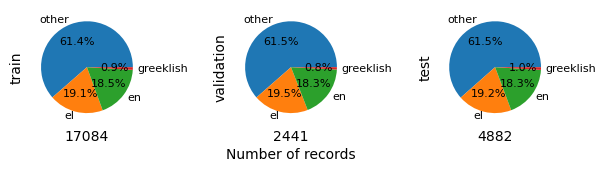

In [36]:
from src.ml import train_test_val_split
import matplotlib.pyplot as plt


data_train, data_val, data_test = train_test_val_split(gold_df, train_ratio=0.7, val_ratio=0.1, test_ratio=0.2,
                                                        random_state=42, stratify_col="labels")
# code block from Ioannis Pavlopoulos
axes = pd.DataFrame({"train": data_train.labels.value_counts(),
              "validation": data_val.labels.value_counts(),
              "test": data_test.labels.value_counts()}
            ).plot.pie(subplots=True, 
                       textprops={'fontsize': 8},
                       autopct=f'%1.1f%%', # print percent% results 
                       legend=False)

axes[0].set_xlabel(data_train.shape[0])
axes[1].set_xlabel(data_val.shape[0])
axes[2].set_xlabel(data_test.shape[0])

axes[1].text(0, -2, 'Number of records', ha='center')

plt.tight_layout(pad=2.0)
plt.show()

In [37]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


vectorizer = TfidfVectorizer().fit(data_train.text)
x_train = vectorizer.transform(data_train.text)
y_train = data_train.labels
x_val = vectorizer.transform(data_val.text)
y_val = data_val.labels
x_test = vectorizer.transform(data_test.text)
y_test = data_test.labels

In [38]:
from sklearn.model_selection import cross_val_score


def cross_val_res(model, x, y, scoring=None, cv=10):
    if scoring is None:
        scoring = "f1_macro"
    res = cross_val_score(model, x, y, cv=cv, scoring=scoring)
    return res

### Dummy Classifier

In [39]:
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import warnings


def get_statistics(y_test, y_pred):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        print(f"Macro F1: {f1_score(y_test, y_pred, average='macro', zero_division=0)}")
        print(classification_report(y_test, y_pred, zero_division=0))
        ConfusionMatrixDisplay.from_predictions(y_test, 
                                                y_pred, 
                                                colorbar=True)
        plt.show()

Macro F1: 0.19046411361907176
              precision    recall  f1-score   support

          el       0.00      0.00      0.00       936
          en       0.00      0.00      0.00       895
   greeklish       0.00      0.00      0.00        47
       other       0.62      1.00      0.76      3004

    accuracy                           0.62      4882
   macro avg       0.15      0.25      0.19      4882
weighted avg       0.38      0.62      0.47      4882



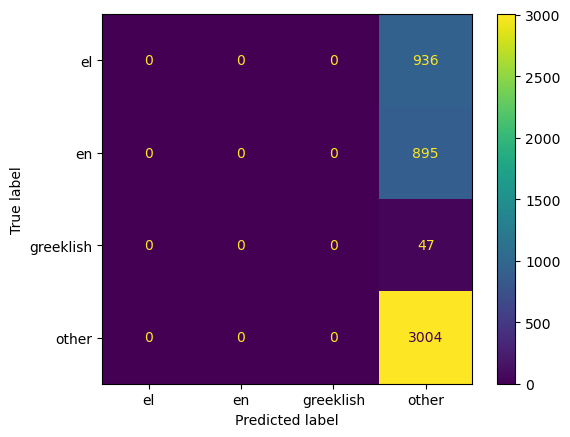

In [40]:
from sklearn.dummy import DummyClassifier, DummyRegressor


majority = DummyClassifier(strategy="most_frequent")
majority.fit(x_train, y_train)
majority_res = majority.predict(x_test)

get_statistics(y_test, majority_res)

### Regex Classification

In [41]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    regex_model = RegexClassifier()
    res = cross_val_res(regex_model, data_train.text, y_train, scoring="f1_macro")
    print(f"Regex Classifier mean macro F1: {res[0]:.4f}, std: {res[1]:.4f}")

Regex Classifier mean macro F1: 0.5083, std: 0.5066


Macro F1: 0.5078605480596232
              precision    recall  f1-score   support

          el       1.00      1.00      1.00       936
          en       0.32      1.00      0.48       895
   greeklish       0.00      0.00      0.00        47
       other       1.00      0.38      0.55      3004

    accuracy                           0.61      4882
   macro avg       0.58      0.59      0.51      4882
weighted avg       0.87      0.61      0.62      4882



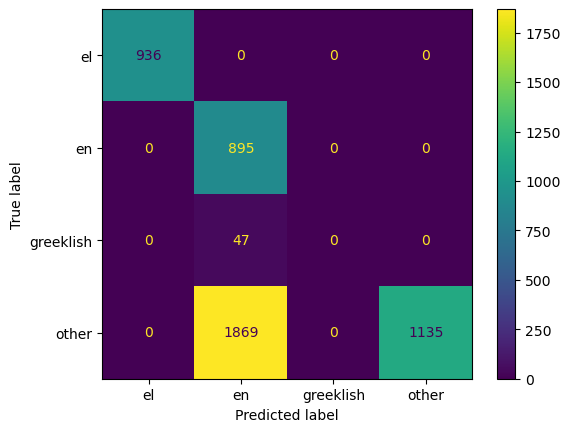

In [42]:
regex_model = RegexClassifier(include_greeklish=True).fit(data_train.text, y_train)
regex_res = regex_model.predict(data_test.text)
get_statistics(y_test, regex_res)

### Logistic Regression

In [43]:
from sklearn.linear_model import LogisticRegression


with warnings.catch_warnings():
    # ignore warnings about deprecated methods in libraries
    warnings.simplefilter("ignore")

    lr = LogisticRegression(max_iter=1000)
    res = cross_val_res(lr, x_train, y_train)
    print(f"Logistic Regression mean macro F1-score {res[0]:.4f}, std: {res[1]:.4f}")

Logistic Regression mean macro F1-score 0.8484, std: 0.8892


Macro F1: 0.907607064300836
              precision    recall  f1-score   support

          el       1.00      0.94      0.97       936
          en       1.00      0.97      0.98       895
   greeklish       1.00      0.53      0.69        47
       other       0.97      1.00      0.98      3004

    accuracy                           0.98      4882
   macro avg       0.99      0.86      0.91      4882
weighted avg       0.98      0.98      0.98      4882



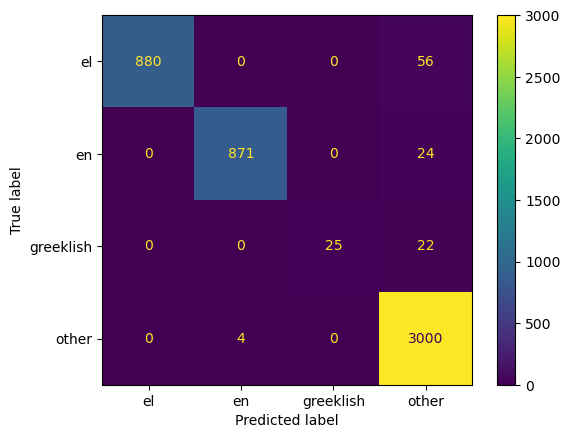

In [44]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    lr = LogisticRegression(max_iter=1000).fit(x_train, y_train)
    lr_res = lr.predict(x_test)

get_statistics(y_test, lr_res)

In [45]:
from sklearn.ensemble import RandomForestClassifier


forest_model = RandomForestClassifier(n_estimators=50, 
                                      n_jobs=-1, 
                                      criterion="entropy")
res = cross_val_res(forest_model, x_train, y_train, cv=3)
print(f"Random Forest mean macro F1: {res[0]:.4f}, std: {res[1]:.4f}")

Random Forest mean macro F1: 0.9316, std: 0.9334


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   14.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.0s finished


Macro F1: 0.9695480255060236
              precision    recall  f1-score   support

          el       1.00      0.98      0.99       936
          en       0.98      1.00      0.99       895
   greeklish       1.00      0.83      0.91        47
       other       0.99      0.99      0.99      3004

    accuracy                           0.99      4882
   macro avg       0.99      0.95      0.97      4882
weighted avg       0.99      0.99      0.99      4882



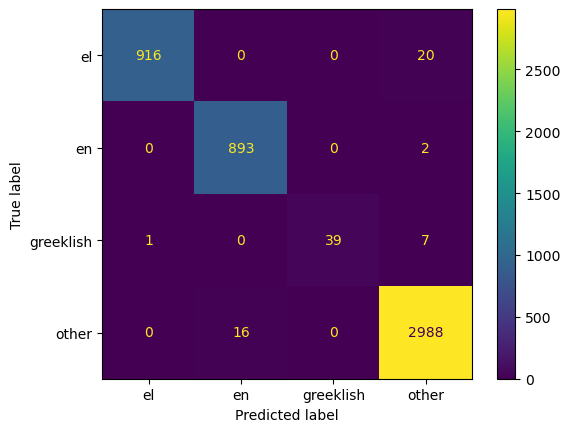

In [46]:
from sklearn.ensemble import RandomForestClassifier


forest_model = RandomForestClassifier(n_estimators=100, 
                                      n_jobs=-1, 
                                      criterion="entropy", 
                                      verbose=1).fit(x_train, y_train)
forest_pred = forest_model.predict(x_test)
get_statistics(y_test, forest_pred)

### Adaboost

In [47]:
from sklearn.ensemble import AdaBoostClassifier


ada_model = AdaBoostClassifier(n_estimators=50)
res = cross_val_res(ada_model, x_train, y_train, cv=3)
print(f"AdaBoost mean macro F1: {res[0]:.4f}, std: {res[1]:.4f}")

AdaBoost mean macro F1: 0.8656, std: 0.8711


Macro F1: 0.9010501269649384
              precision    recall  f1-score   support

          el       0.99      0.89      0.94       936
          en       0.98      0.96      0.97       895
   greeklish       0.78      0.68      0.73        47
       other       0.95      0.99      0.97      3004

    accuracy                           0.96      4882
   macro avg       0.93      0.88      0.90      4882
weighted avg       0.96      0.96      0.96      4882



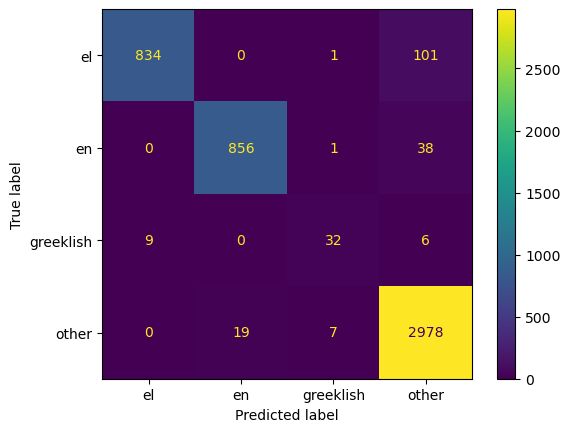

In [48]:
ada_model = AdaBoostClassifier(n_estimators=100).fit(x_train, y_train)
ada_pred = ada_model.predict(x_test)
get_statistics(y_test, ada_pred)

In [49]:
missed = y_test != ada_pred
pd.DataFrame({"predicted": ada_pred[missed], "actual": data_test[missed].labels, "text": data_test[missed].text})

,predicted,actual,text
7466,other,en,Works better than expected
1738,other,el,Όλα τα μάτια στράφηκαν σ ' αυτόν .
6062,other,el,"Αλήθεια , πού ζείτε τώρα ;"
795,other,en,Exactly what I was hoping I would get.
15584,greeklish,other,"To na pewno nie jest to, co było dawniej."
...,...,...,...
6271,other,el,"Ω , Θεέ μου , την αγαπώ ."
18396,greeklish,other,"Która rzeczniczka Maria Cheng zgodziła się, mó..."
8100,other,el,καλά μου φαίνεται ότι πληρώνω ούτως ή άλλως γι...
3463,other,el,Είχε προβλέψει αυτή τη σύλληψη ;


In [50]:
missed = y_test != forest_pred
pd.DataFrame({"predicted": forest_pred[missed], "actual": data_test[missed].labels, "text": data_test[missed].text})

,predicted,actual,text
4026,other,el,Η αποικία σιγά σιγά έγινε καλύτερα οργανωμένη .
2696563,other,greeklish,"tipota se pvp den exei oloi pve kanete?? -,-"
16308,en,other,"U will need to take care here , as there may b..."
3107924,other,greeklish,K r o b a i n h
2434,other,el,Φαγητό : 4 αστέρια .
11263,en,other,And you know you are my husband and i love you...
878,other,el,Κοίταξα γύρω .
19926,en,other,Oh really well nikiwa england years ago na nik...
1444,other,el,"Τίποτα , κυρία κάβεντις ;"
11369,en,other,Just how wise katibu mwema


### Hyperparameter tuning

In [51]:
estimators = []
scores = []

for n_estimators in tqdm([int(x) for x in np.linspace(start = 50, stop = 1000, num = 10)]):
    estim = RandomForestClassifier(n_estimators=n_estimators, 
                                  n_jobs=-1, 
                                  criterion="entropy").fit(x_train, y_train)
    score = f1_score(y_val, estim.predict(x_val), average='macro', zero_division=0)

    estimators.append(estim)
    scores.append(score)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [12:57<00:00, 77.73s/it]


In [52]:
best_model = estimators[np.argmax(scores)]

print(f"Best model {best_model} with macro F1 score of {max(scores)}")

Best model RandomForestClassifier(criterion='entropy', n_estimators=788, n_jobs=-1) with macro F1 score of 0.9727416968503323


### Annotating the operational dataset

In [53]:
x_oper = vectorizer.transform(crawl_df.text)
crawl_df["language"] = best_model.predict(x_oper)


In [54]:
csv_output(crawl_df, "crawl.csv")

File saved successfully as output\crawl.csv


In [55]:
print(f"Notebook executed in {int((time()-start)// 60)} minutes and {(time()-start) % 60:.1f} seconds")

Notebook executed in 26 minutes and 59.3 seconds
